ドライバのマウント

In [2]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


初期宣言

In [3]:
from PIL import Image,ImageFile
import os,glob
import numpy as np

n_categories=2
batch_size = 32
label_lists = ["me","notme"]
train_dataset = "./drive/My Drive/me_or_notme/train/"
val_dataset = "./drive/My Drive/me_or_notme/val/"
file_name = 'vgg16_me_or_notme_file'


モデルの作成

In [4]:
from keras.models import Model,Sequential
from keras.layers import Dense, GlobalAveragePooling2D,Input,Flatten
from keras.layers import Dropout,Input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger



base_model=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))
#転移学習のため全結合層を新たに追加
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation = 'relu'))
top_model.add(Dropout(0.5))
if n_categories == 2:
    top_model.add(Dense(1, activation='sigmoid'))
    crossentropy = 'binary_crossentropy'
else:
    top_model.add(Dense(n_categories, activation = 'softmax'))
    crossentropy = 'categorical_crossentropy'
base_model.trainable = False
model = Model(base_model.input, top_model(base_model.output))
print("\n-----------------------Model details---------------------------------------------------------------------")

model.summary()

model.compile(optimizer=SGD(lr=1e-3, momentum=0.9),
                loss=crossentropy,
                metrics = ['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step

-----------------------Model details---------------------------------------------------------------------
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (

trainの学習準備

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
            rescale=1./255,
            brightness_range=[0.5,1.5],
            horizontal_flip=True)

if n_categories == 2:
    #二値分類の場合はbinary
    sel_class_mode = 'binary'
else:
    # 多分類のため categorical
    sel_class_mode ='categorical'
train_generator = train_datagen.flow_from_directory(
    # trainデータのディレクトリ
    train_dataset,
    target_size=(224,224),
    batch_size= 16,  # バッチサイズ
    class_mode=sel_class_mode)
   

Found 370 images belonging to 2 classes.


validationの学習準備

In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dataset,
    target_size=(224,224),
    batch_size =4,
    class_mode=sel_class_mode)

Found 20 images belonging to 2 classes.


作成された学習済みモデルの保存場所の作成

In [7]:
save_model_path = "./drive/My Drive/me_or_notme/model/" 
if not os.path.exists(save_model_path):
        print('make ', save_model_path)
        os.mkdir(save_model_path)

学習

In [8]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_earlystopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join(save_model_path , 'model_{epoch:03d}_val_accuracy_{val_accuracy:.4f}.h5'),
                            monitor='val_accuracy',
                            save_best_only=True,
                            save_weights_only=False,
                            mode='max',
                            verbose=1,
                            period=1)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=2,
    callbacks=[model_earlystopping,model_checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7625
Epoch 00001: val_accuracy improved from -inf to 0.87500, saving model to ./drive/My Drive/me_or_notme/model/model_001_val_accuracy_0.8750.h5
10/10 [==============================] - 36s 4s/step - loss: 0.4861 - accuracy: 0.7625 - val_loss: 0.2878 - val_accuracy: 0.8750
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8938
Epoch 00002: val_accuracy improved from 0.87500 to 1.00000, saving model to ./drive/My Drive/me_or_notme/model/model_002_val_accuracy_1.0000.h5
10/10 [==============================] - 21s 2s/step - loss: 0.2856 - accuracy: 0.8938 - val_loss: 0.0661 - val_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9625
Epoch 00003: val_accuracy did not improve from 1.00000
10/10 [==============================] - 9s 

学習結果をグラフに出力

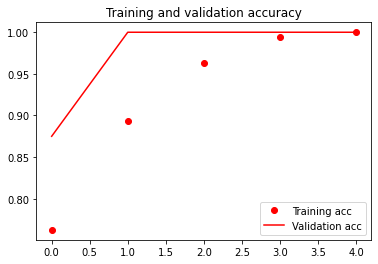

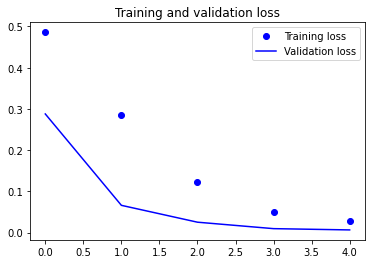

In [12]:
import matplotlib.pyplot as plt
# グレフの表示の準備
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
# グラフを表示
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('./drive/My Drive/me_or_notme/model/acc.png')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('./drive/My Drive/me_or_notme/model/loss.png')

#    plt.show()
model.save(save_model_path+'vgg16_last_model.h5')